In [130]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(comment='Sample Graph')

# Adding nodes
dot.node('A', 'Start')
dot.node('B', 'Middle')
dot.node('C', 'End')

# Adding edges between nodes
dot.edge('A', 'B', label='goes to')
dot.edge('B', 'C', label='leads to')

# Render the graph to a file (e.g., in .pdf or .png format)
#dot.render('sample_graph', format='png', view=True)


In [2]:
!pip install micrograd


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [101]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [11]:
def f(x):
    return 3*x**2 - 4*x+5

In [12]:
f(3.0)

20.0

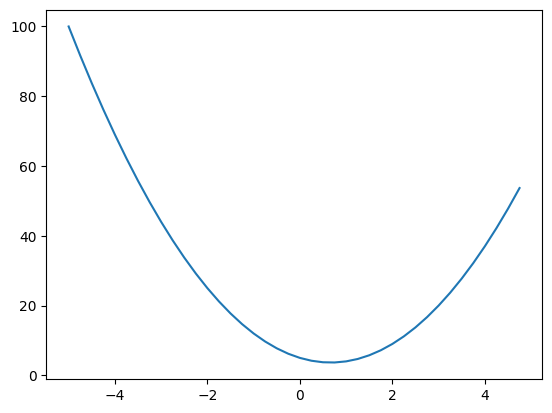

In [18]:
xs = np.arange(-5, 5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [33]:
x=2/3
h=0.00000001
dx = (f(x+h) - f(x))/h
dx


0.0

In [42]:
h=0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c
print ('d1', d1)
print ('d2',d2)
print('slope',(d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [6]:
class Value:
    def __init__(self, data=None, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)  # this line convers the normal integer or float to a Value object
        out = Value(self.data + other.data,(self, other),'+')
        def _backward():  # assigns the gradient 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward  # function backward is called where where value of grad being updated on the children classes
        return out

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)   # this line convers the normal integer or float to a Value object
        out = Value(self.data * other.data,(self, other),'*')
        def _backward():
             self.grad += other.data * out.grad
             other.grad += self.data * out.grad
        out._backward = _backward  # function backward is called where where value of grad being updated on the children classes
        return out

    def __pow__(self, other):
        assert isinstance(other, (int,float)) #"only support int or float powers now"
        out = Value( self.data**other,(self,),f'**{other}')
        def _backward():
             self.grad += other * (self.data**(other-1)) * out.grad 
        out._backward = _backward  # function backward is called where where value of grad being updated on the children classes
        return out


    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):  # self /other
        return self * other**-1

    def __neg__(self):  # negative of the input
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):  # New: Handle float - Value
        other = other if isinstance(other, Value) else Value(other)
        return other + (- self)
# needed specifically for MLP tanh function
     
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)  # math.exp(1) is euler's number
        out = Value(t,(self,),'tanh')
        def _backward():
             self.grad += (1 - t**2) * out.grad
 
        out._backward = _backward  # function backward is called where where value of grad being updated on the children classes
        
        return out
   
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
             self.grad += out.data * out.grad
 
        out._backward = _backward  # function backward is called where where value of grad being updated on the children classes
        
        return out
       
    
    # This function is build ordering of the nodes in the graph from top to bottom. Topoloigical sort
    def backward(self):
        topo = []
        visited = set()
 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) 
        
        build_topo(self)
    
    # calling above function to apply the topological sort to the same 
        self.grad = 1.0
        for node in reversed(topo):  # because the top node is added at the bottom. we want to start from the same for assigning the grad values
            node._backward()

a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10.0,label = 'c')
e = a*b;e.label = 'e'
d = c + e
d.label = 'd'
f = Value(-2, label = 'f')
L=d*f; L.label = 'L'
L

Value(data=-8.0, label=L)

In [123]:
 a = Value(2.0)
 b = Value(3.0)

a - 2

Value(data=0.0, label=)

In [12]:
from graphviz import Digraph

#root = Value()
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
   # root, v, child = Value()
    def build(v=None):
        if v  not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges


def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir':'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it

        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            # and connect this node for it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

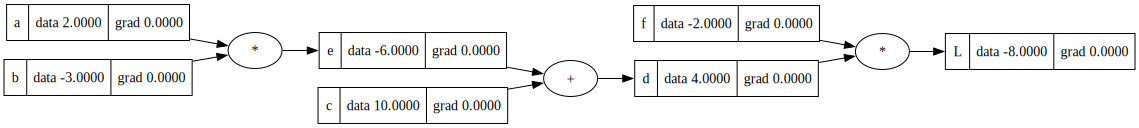

In [104]:
draw_dot(L)

In [122]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

In [ ]:
print (L.data)

In [105]:
math.exp(1)


2.718281828459045

In [71]:
L.grad = 1
d.grad = -2 #(l = d*f and  dl/dd = f as per calculus)
f.grad = 4
c.grad = -2# (chain rule of dz/dx = dz/dy*dy/dx ==> dL/de = dL/dd*dd/de
e.grad = -2 
b.grad = -4
a.grad = 6

In [135]:
def lol():
    h=0.0001
    
    a = Value(2.0,label = 'a')
    b = Value(-3.0,label = 'b')
    c = Value(10.0,label = 'c')
    e = a*b;e.label = 'e'
    d = c + e
    d.label = 'd'
    f = Value(-2, label = 'f')
    L=d * f; L.label = 'L'
    L1 = L.data
    
    
    a = Value(2.0  ,label = 'a')  #if we add h here, it is derivative of L wrt to a
  
    b = Value(-3.0,label = 'b')
    b.data += h
    c = Value(10.0,label = 'c')
    e = a*b;e.label = 'e'
    d = c + e
    
    d.label = 'd'
    f = Value(-2 , label = 'f')
    L= d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h) # derivative of L wrt to f

In [63]:
lol()

-4.000000000008441


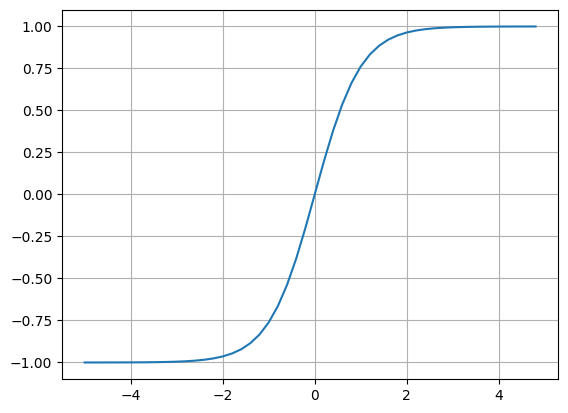

In [82]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));plt.grid()

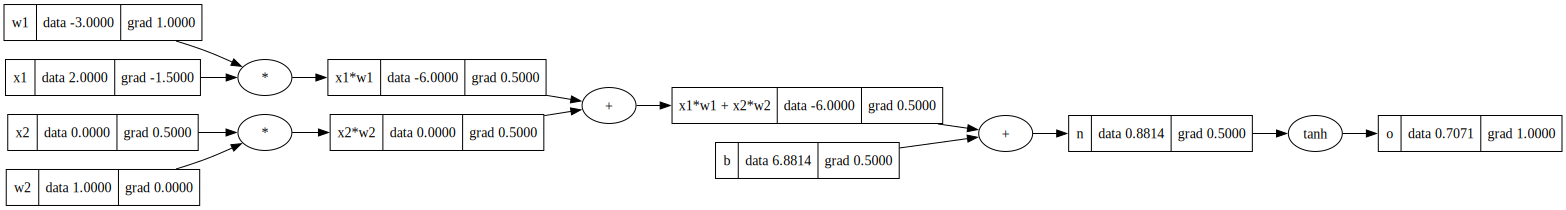

In [139]:
# explain the concept of the multilayer perceptron
# input x1, x2
x1 = Value(2.0 , label ='x1' )
x2 = Value(0.0 , label ='x2' )

# synapse or weights w1, w2
w1 = Value(-3.0 , label ='w1' )
w2 = Value(1.0 , label ='w2' )

#bias of the neuron
b = Value(6.8813735870195432, label = 'b')# due to specific reason this number was chosed

# Products of weights and input of the neuron
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

# Sum of all the inputs
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Sum of all the inputs and the bias
n = x1w1x2w2 + b ; n.label = 'n'  # this is the final output without activation function

# final output after applying tanh (squashing function or activation function)
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

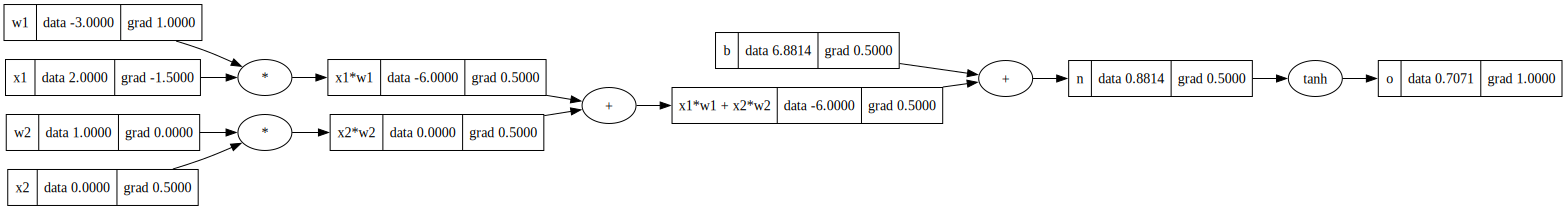

In [108]:
#calculate derivatives of each data and weights with respect to the output --> d/do
o.grad = 1   # do/do = 1

# o = tanh(n)
#do/dn = 1- tanh**2 # as per the formula
n.grad = (1- 0.7071*0.7071)

# say L = x1*w1 + x2*w2 
# n = L + b
# do/dL = (dn/dL)*(do/dn) # markov's chain rule==> 1 * 0.5

x1w1x2w2.grad = 0.5
# similarly
b.grad = 0.5

x1w1.grad = 0.5 # for '+' symbol the grad just flow backwards into child nodes(x1*w1 + x2*w2)
x2w2.grad = 0.5

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data


draw_dot(o)

In [118]:
o.grad = 1.0  # need to be initialized for the final output node becuase it is 0 by default.

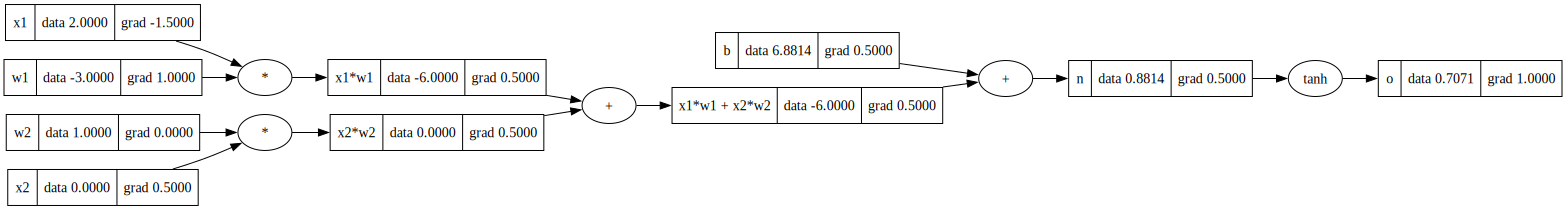

In [142]:
draw_dot(o)

In [120]:
o._backward()

In [122]:
n._backward()

In [124]:
x1w1x2w2._backward()

In [126]:
x1w1._backward()

In [127]:
x2w2._backward()

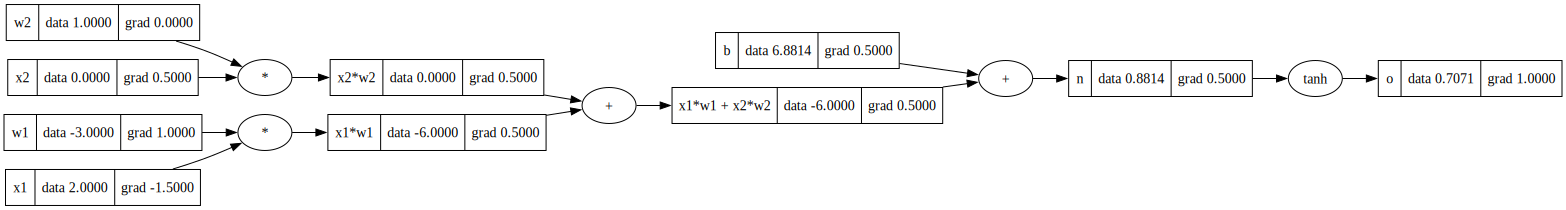

In [152]:
draw_dot(o)

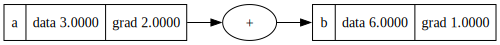

In [68]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

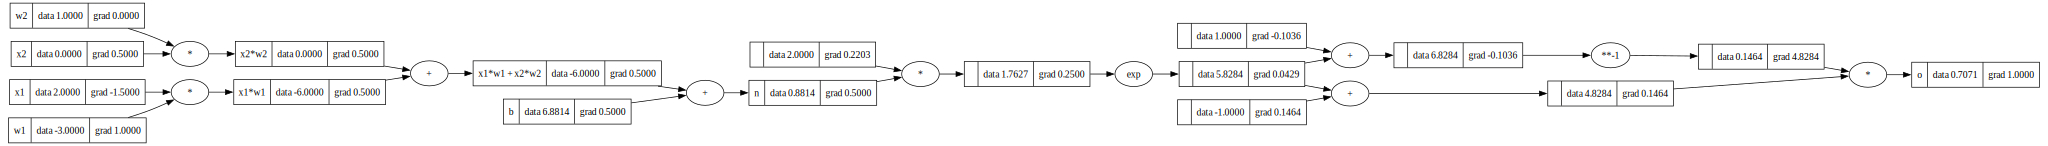

In [140]:
# explain the concept of the multilayer perceptron
# input x1, x2
x1 = Value(2.0 , label ='x1' )
x2 = Value(0.0 , label ='x2' )

# synapse or weights w1, w2
w1 = Value(-3.0 , label ='w1' )
w2 = Value(1.0 , label ='w2' )

#bias of the neuron
b = Value(6.8813735870195432, label = 'b')# due to specific reason this number was chosed

# Products of weights and input of the neuron
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

# Sum of all the inputs
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Sum of all the inputs and the bias
n = x1w1x2w2 + b ; n.label = 'n'  # this is the final output without activation function

# Change O how we define it using the actual mathemtical logic of exp function

# ------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ------------



o.label = 'o'
o.backward()
draw_dot(o)

In [294]:
import torch
print(torch.__version__)

2.6.0+cpu


In [11]:
# pytorch starts here
import torch

In [296]:
x1 = torch.Tensor([2.0]).double()                               ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                               ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                               ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                               ;w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432]).double()                ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())  # this is called forward pass

o.backward()  # this is similar to backward used in micrograd
print("--------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print("--------")
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
--------
x2 0.5000001283844369
w2 0.0
--------
x1 -1.5000003851533106
w1 1.0000002567688737


In [93]:
torch.Tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]]).shape

torch.Size([2, 3])

In [94]:
torch.Tensor([4]).dtype

torch.float32

In [9]:
import math
import random
class Neuron:  # defining one single node in a neural network, we call in neuron, it may have multiple inputs x and weights - w.
    # this class can be given predefined number of Weights 
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # it is creating and initializing the the array of objects for the number of inputs of the neuron, yes '_' can be used
        self.b = Value(random.uniform(-1,1)) # it is creating the bias on the neuron 'b'

    def __call__(self, y):  # this  function responsible to implement the calling the instace of object with input x i.e. n(x)
        # w * x + b
        #act = sum((wi*yi for wi,yi in zip(self.w,y)) + self.b)   # ERROR, diversion from Andrej's code as it did not work for me
        act = sum((wi*yi for wi,yi in zip(self.w,y)), Value(0.0)) + self.b  # ERROR, diversion from Andrej's code as it did not work for me
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout): # nout is total number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]  # Create neuron for each layer 

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    

    
x = [2.0 , 3.0 , -1.0]
n = MLP(3,[4, 4, 1])
n(x)

Value(data=-0.6427502075448136, label=)

In [10]:
draw_dot(n(x))

NameError: name 'draw_dot' is not defined

In [13]:
nin = 2
nouts = [0.5, 0.3, 0.6, 0.8, 0.9]
sz = [nin] + nouts
sz

[2, 0.5, 0.3, 0.6, 0.8, 0.9]

In [14]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

ys = [1.0,-1.0,-1.0,1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.6427502075448136, label=),
 Value(data=-0.8820069538961757, label=),
 Value(data=-0.6411007262187074, label=),
 Value(data=-0.7617183488982026, label=)]

In [15]:
[(yout - ygt)**2 for ygt,yout in zip(ys,ypred)]

[Value(data=2.6986282443885283, label=),
 Value(data=0.013922358928859213, label=),
 Value(data=0.12880868872073922, label=),
 Value(data=3.1036515408446084, label=)]

In [18]:
loss = sum(((yout - ygt)**2 for ygt,yout in zip(ys,ypred)),Value(0.0)) # changed the code viz a viz original Andrej's code

In [19]:
loss

Value(data=5.945010832882735, label=)

In [20]:
loss.backward()

In [21]:
n.layers[0].neurons[0].w[0].grad

0.006578417836530118

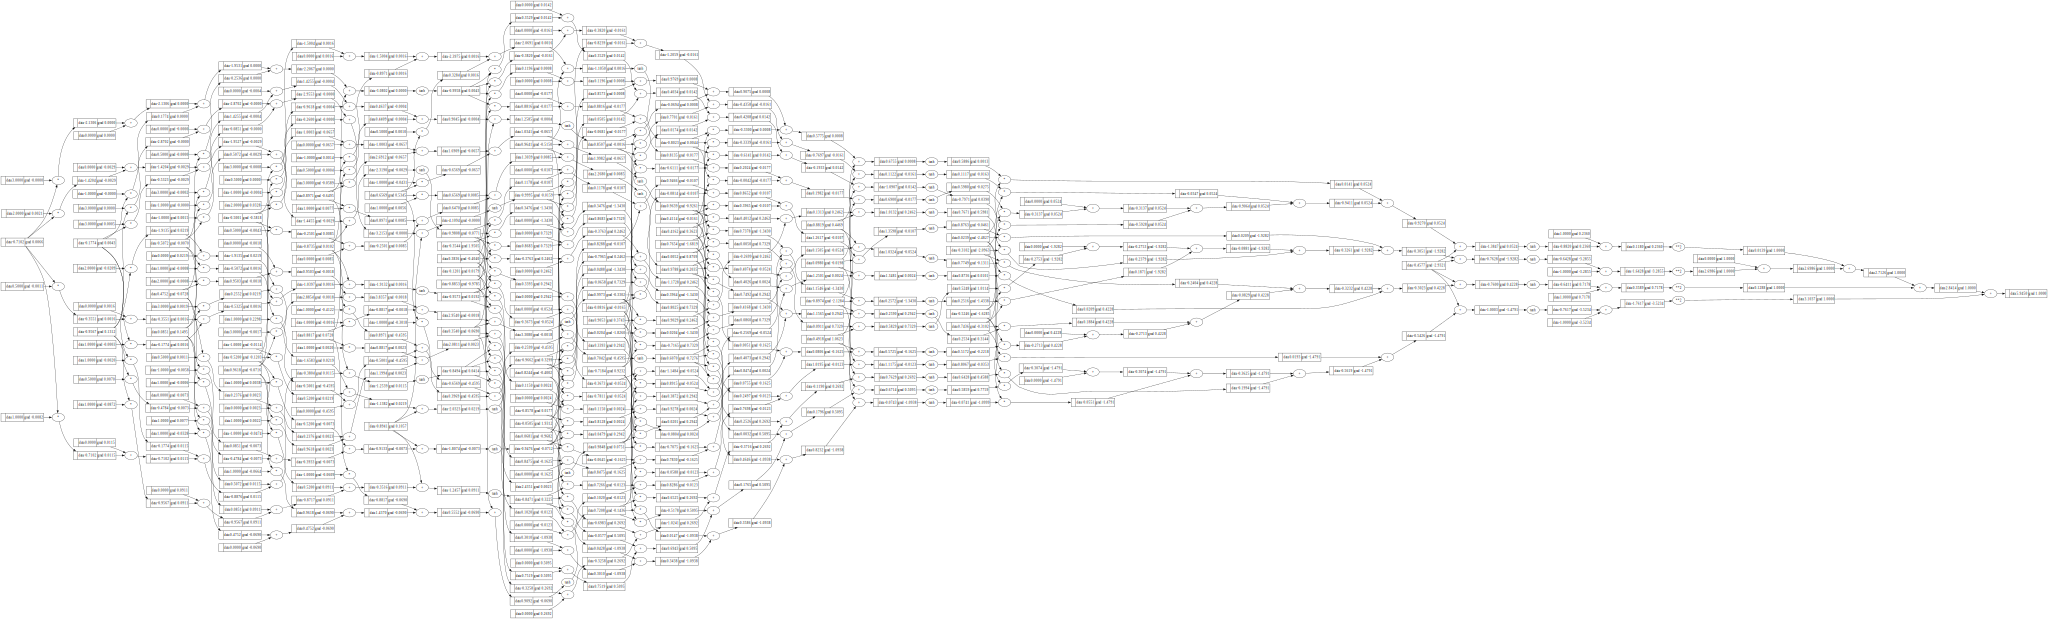

In [22]:
draw_dot(loss)